<a href="https://colab.research.google.com/github/lomovtsevp/diploma-real-time-emotions-recognition/blob/main/DIPLOMA_FACE_EMOTIONS_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>0. Установка и импорт библиотек, необходимых для решения задачи

In [76]:
#Устанавливаем библиотеку для аугментации картинок
! pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
import torch
from torch.utils import data
import pandas as pd
import albumentations
from albumentations import pytorch as AT
from tqdm import tqdm
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline 
import torch.nn.functional as F
import torchvision.models as models
from torch import nn
#from torchsummary import summary
from collections import OrderedDict
import torch.optim as optim

<font size=6><b>1.Считывание данных и их предобработка. Первичный анализ данных (EDA)

In [78]:
#Проверка возможности работы на GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [79]:
#Считываем данные FER2013
df = pd.read_csv('https://vk.com/doc296252774_643448616?hash=TpIKEuEC3ZdxKzqqUejXFzhSUJ9U26wI2OQvLWeT2uL&dl=0S5aHfbhBFP6ZfIhPC41y6qDIw0vBKJa2H0BkZXdChT')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [80]:
#Смотрим, какие есть варианты использования данных
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [81]:
#проверяем количество строк в каждом из датасетов
print(len(df[df['Usage']=='Training']))
print(len(df[df['Usage']=='PublicTest']))
print(len(df[df['Usage']=='PrivateTest']))

28709
3589
3589


In [82]:
#Добавляем новый столбец, где пиксели будут уже списком из целочисленных значений
df['pixelss'] = [[int(y) for y in x.split()] for x in df['pixels']]

In [83]:
df.head()

,emotion,pixels,Usage,pixelss
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [84]:
#Разобьем датасет на тренировочный, валидационный и тестовый
df_train = df[df['Usage']=='Training']
df_valid = df[df['Usage']=='PrivateTest']
df_test = df[df['Usage']=='PublicTest']

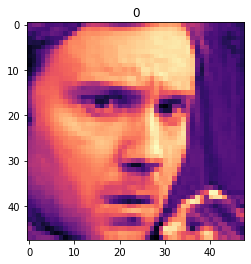

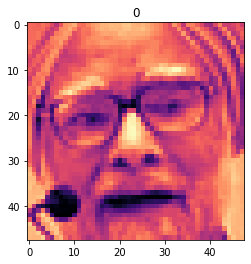

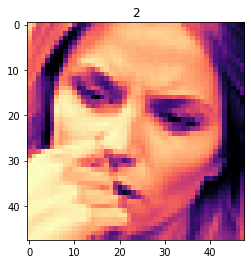

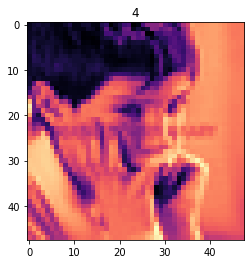

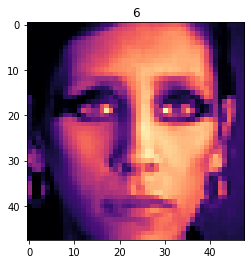

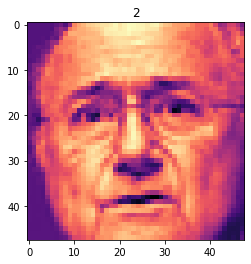

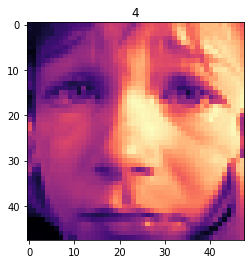

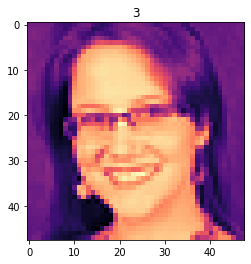

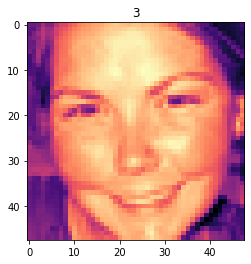

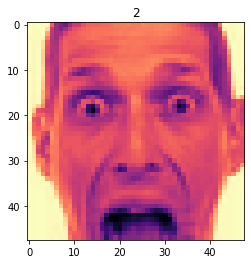

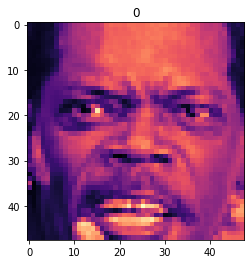

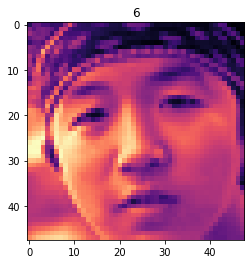

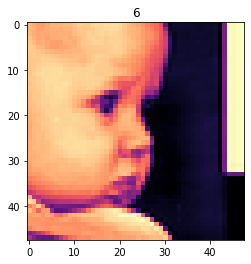

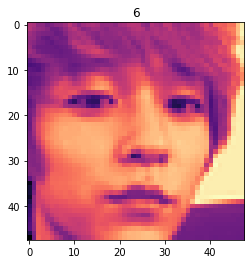

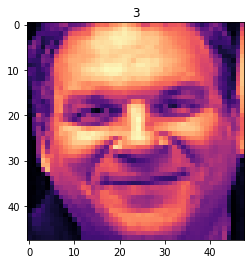

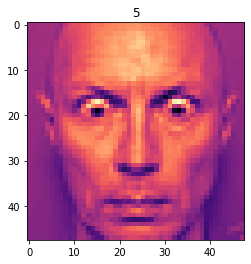

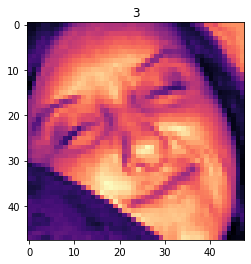

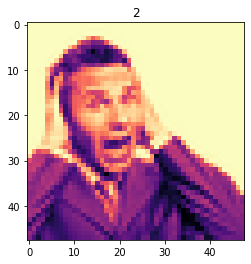

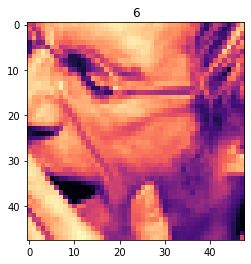

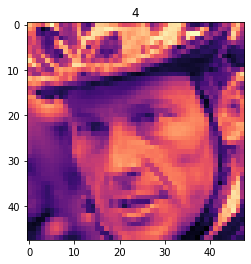

In [85]:
#посмотрим, что за картинки в наборе данных
for i in range(20):
  plt.figure()
  image = np.array(df_train['pixelss'][i]).reshape(48, 48)
  plt.imshow(image, interpolation='nearest',cmap='magma')
  plt.title(df_train['emotion'][i])
  plt.show()

In [86]:
#Создадим словарь, в котором будут храниться метки изображений
labels_dict = {0 : 'Злость',
               1 : 'Раздражение',
               2 : 'Ужас',
               3 : 'Счастье',
               4 : 'Грусть',
               5 : 'Удивление',
               6 : 'Без эмоций'}

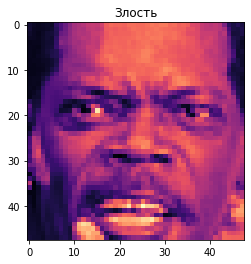

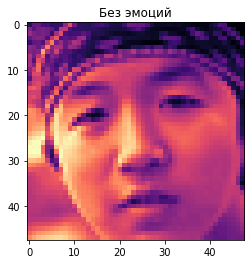

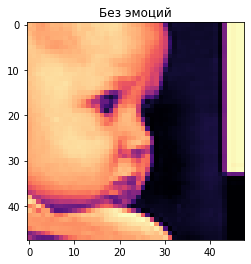

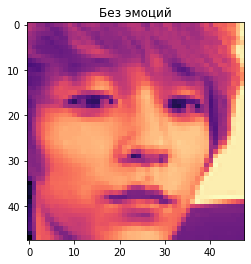

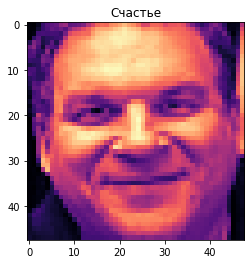

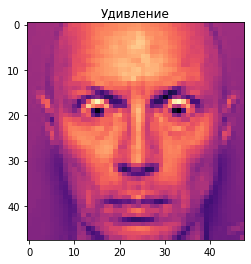

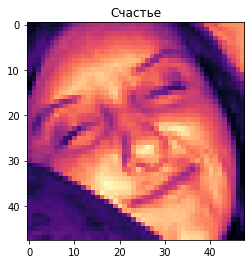

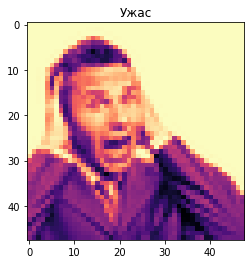

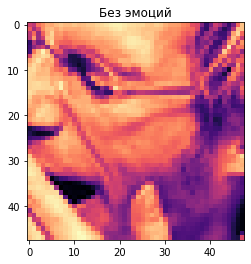

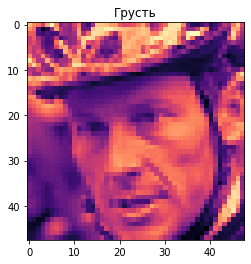

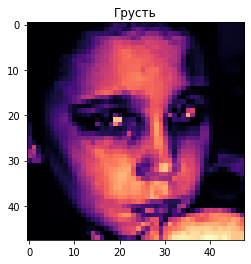

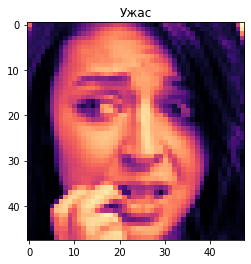

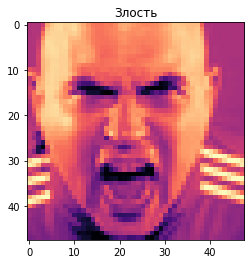

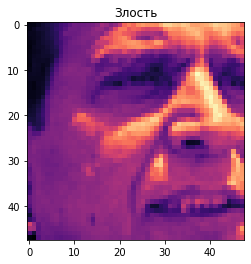

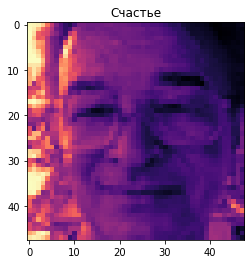

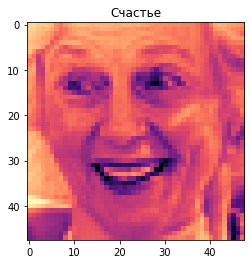

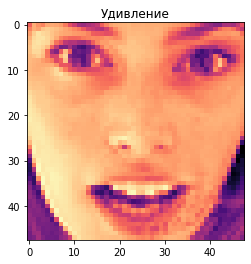

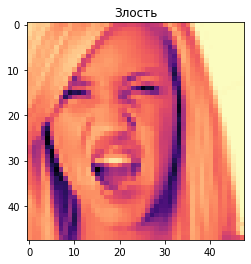

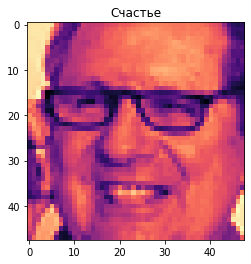

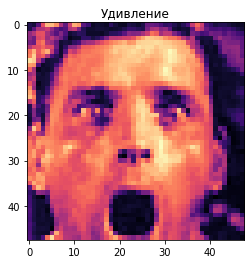

In [87]:
#Отобразим картинки с размеченными эмоциями
for i in range(20):
  plt.figure()
  image = np.array(df_train['pixelss'][i+10]).reshape(48, 48)
  plt.imshow(image, interpolation='nearest',cmap='magma')
  plt.title(labels_dict[df_train['emotion'][i+10]])
  plt.show()

In [88]:
#Создадим списки с индексами выборок
part={}
part['train'] = list(range(0,len(df_train)))
part['valid'] = list(range(0,len(df_valid)))
part['test'] = list(range(0,len(df_test)))
train_labels = df_train['emotion'].tolist()
valid_labels = df_valid['emotion'].tolist()
test_labels = df_test['emotion'].tolist()

<font size=6><b>2. Преобразование датасета для построения нейронной сети

In [89]:
#Создадим класс Dataset для совместимости с библиотекой Pytorch, который унаследывается от класса data.Dataset. Он позволит нам преобразовать данные в формат,
#необходимый для обучения модели
class FER2013(data.Dataset):

  def __init__(self, dff, transforms):
        self.transforms = transforms
        self.dff=dff

  def __len__(self):
        return len(self.dff)

  def __getitem__(self, index):

        X = self.dff.iloc[index]['pixelss']
        X = np.array(X).reshape(48,48,1)
        y = self.dff.iloc[index]['emotion']

        if self.transforms:
          X = self.transforms(X)
        
        X = torch.cat((X,X,X),0)

        return X, y

In [90]:
#Инициализируем параметры для DataLoader
params = {'batch_size': 64,'shuffle': True,'num_workers': 10}

In [91]:
#Создадим класс, который подготовит датасеты для DataLoader. Используя библиотеку albumentations, мы добавим данных к нашему датасету, произведя аугментацию изображений.
class Augmentations(object):
    def __init__(self,split):
        self.split=split
        self.aug=albumentations.Compose([                                         
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()
    ])
	
        if self.split=='train':
            self.aug=albumentations.Compose([

    albumentations.HorizontalFlip(),
    albumentations.Cutout(2,2,2,0.5),
    albumentations.GaussNoise(),
    #albumentations.HueSaturationValue(0.2),
    albumentations.RandomRotate90(),    
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()    
    ])
            
    def __call__(self,img):
        #img = np.array(img)
        img = self.aug(image=img)['image']
        return img

In [92]:
#Получаем трансформированные датасеты и загружаем их в DataLoader.
train_transforms , validation_transforms = Augmentations('train'), Augmentations('test')

training_set = FER2013(df_train, train_transforms)
training_generator = data.DataLoader(training_set, **params)

validation_set = FER2013(df_valid, validation_transforms)
validation_generator = data.DataLoader(validation_set, **params)

test_set = FER2013(df_test, validation_transforms)
test_generator = data.DataLoader(test_set, **params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [93]:
#Построение кривых потерь и точности
def plot(train_losses,train_acc,test_losses,test_acc, label):
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses, label=label)
  axs[0].set_title("Функция потерь на тестовой выборке")
  axs[1].plot(test_acc, label=label)
  axs[1].set_title("Точность (Accuracy) на тестовой выборке")

In [94]:
#Функция для отслеживания параметра "шаг обучения"
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

<font size=6><b>3. Построение нейронной сети

In [95]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Первый сверточный слой
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)            
         ) 

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)            
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)   
        x = self.convblock8(x) 
        x = self.convblock9(x)    
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [96]:
#Функция для обучения нейронной сети
def train(model, train_loader, optimizer,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  running_loss = 0.0
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss()

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    running_loss += loss.item()
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} running_loss={running_loss} threshold={best_loss*(0.996)}')
    train_acc.append(100*correct/processed)
    pbar.set_description(desc= f'Потери={loss.item()} Номер пакета={batch_idx} Шаг обучения={get_lr(optimizer)} Точность={100*correct/processed:0.2f}')

In [97]:
#Функция для тестирования нейронной сети
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    print('\nТестовый набор: Средние потери: {:.4f}, Точность: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    valid_acc.append(100. * correct / len(test_loader.dataset))

<font size=6><b>4. Обучение и тестирование работы нейронной сети

Эпоха 0: LR: 0.0019999999999999983


Потери=1.7160372734069824 Номер пакета=448 Шаг обучения=0.0030634337130716477 Точность=24.06: 100%|██████████| 449/449 [01:12<00:00,  6.16it/s]



Тестовый набор: Средние потери: 0.0273, Точность: 1155/3589 (32.18%)

Эпоха 1: LR: 0.0030634337130716477


Потери=1.7532063722610474 Номер пакета=448 Шаг обучения=0.006002425682931637 Точность=30.40: 100%|██████████| 449/449 [01:15<00:00,  5.92it/s]



Тестовый набор: Средние потери: 0.0227, Точность: 1636/3589 (45.58%)

Эпоха 2: LR: 0.006002425682931637


Потери=1.58762526512146 Номер пакета=448 Шаг обучения=0.010122437433314183 Точность=33.55: 100%|██████████| 449/449 [01:17<00:00,  5.82it/s]



Тестовый набор: Средние потери: 0.0208, Точность: 1771/3589 (49.35%)

Эпоха 3: LR: 0.010122437433314183


Потери=1.7036194801330566 Номер пакета=448 Шаг обучения=0.014449833543417487 Точность=35.56: 100%|██████████| 449/449 [01:17<00:00,  5.81it/s]



Тестовый набор: Средние потери: 0.0210, Точность: 1817/3589 (50.63%)

Эпоха 4: LR: 0.014449833543417487


Потери=1.4656953811645508 Номер пакета=448 Шаг обучения=0.017961969810286214 Точность=37.04: 100%|██████████| 449/449 [01:17<00:00,  5.83it/s]



Тестовый набор: Средние потери: 0.0207, Точность: 1772/3589 (49.37%)

Эпоха 5: LR: 0.017961969810286214


Потери=1.4932582378387451 Номер пакета=448 Шаг обучения=0.019828863098122623 Точность=37.48: 100%|██████████| 449/449 [01:16<00:00,  5.84it/s]



Тестовый набор: Средние потери: 0.0187, Точность: 2033/3589 (56.65%)

Эпоха 6: LR: 0.019828863098122623


Потери=1.3436931371688843 Номер пакета=448 Шаг обучения=0.01997270340423158 Точность=38.17: 100%|██████████| 449/449 [01:16<00:00,  5.86it/s]



Тестовый набор: Средние потери: 0.0185, Точность: 1986/3589 (55.34%)

Эпоха 7: LR: 0.01997270340423158


Потери=1.575943946838379 Номер пакета=448 Шаг обучения=0.01980732115328246 Точность=39.45: 100%|██████████| 449/449 [01:16<00:00,  5.84it/s]



Тестовый набор: Средние потери: 0.0186, Точность: 2001/3589 (55.75%)

Эпоха 8: LR: 0.01980732115328246


Потери=1.5372071266174316 Номер пакета=448 Шаг обучения=0.019494429167601215 Точность=39.79: 100%|██████████| 449/449 [01:16<00:00,  5.86it/s]



Тестовый набор: Средние потери: 0.0175, Точность: 2097/3589 (58.43%)

Эпоха 9: LR: 0.019494429167601215


Потери=1.5378471612930298 Номер пакета=448 Шаг обучения=0.019038733633893166 Точность=40.16: 100%|██████████| 449/449 [01:16<00:00,  5.86it/s]



Тестовый набор: Средние потери: 0.0179, Точность: 2053/3589 (57.20%)

Эпоха 10: LR: 0.019038733633893166


Потери=1.3964704275131226 Номер пакета=448 Шаг обучения=0.018447088637147856 Точность=40.31: 100%|██████████| 449/449 [01:16<00:00,  5.88it/s]



Тестовый набор: Средние потери: 0.0174, Точность: 2128/3589 (59.29%)

Эпоха 11: LR: 0.018447088637147856


Потери=1.2754031419754028 Номер пакета=448 Шаг обучения=0.017728393068821027 Точность=41.26: 100%|██████████| 449/449 [01:16<00:00,  5.85it/s]



Тестовый набор: Средние потери: 0.0172, Точность: 2144/3589 (59.74%)

Эпоха 12: LR: 0.017728393068821027


Потери=1.490704894065857 Номер пакета=448 Шаг обучения=0.016893456779224002 Точность=41.15: 100%|██████████| 449/449 [01:16<00:00,  5.89it/s]



Тестовый набор: Средние потери: 0.0165, Точность: 2179/3589 (60.71%)

Эпоха 13: LR: 0.016893456779224002


Потери=1.5385507345199585 Номер пакета=448 Шаг обучения=0.015954837987313175 Точность=41.91: 100%|██████████| 449/449 [01:16<00:00,  5.88it/s]



Тестовый набор: Средние потери: 0.0163, Точность: 2208/3589 (61.52%)

Эпоха 14: LR: 0.015954837987313175


Потери=1.512555480003357 Номер пакета=448 Шаг обучения=0.014926654393387674 Точность=42.04: 100%|██████████| 449/449 [01:16<00:00,  5.87it/s]



Тестовый набор: Средние потери: 0.0163, Точность: 2233/3589 (62.22%)

Эпоха 15: LR: 0.014926654393387674


Потери=1.2666276693344116 Номер пакета=448 Шаг обучения=0.013824370835736084 Точность=42.69: 100%|██████████| 449/449 [01:16<00:00,  5.87it/s]



Тестовый набор: Средние потери: 0.0159, Точность: 2253/3589 (62.78%)

Эпоха 16: LR: 0.013824370835736084


Потери=1.5964367389678955 Номер пакета=448 Шаг обучения=0.012664566685073859 Точность=43.27: 100%|██████████| 449/449 [01:16<00:00,  5.88it/s]



Тестовый набор: Средние потери: 0.0163, Точность: 2178/3589 (60.69%)

Эпоха 17: LR: 0.012664566685073859


Потери=1.6396832466125488 Номер пакета=448 Шаг обучения=0.011464686475375662 Точность=43.24: 100%|██████████| 449/449 [01:16<00:00,  5.88it/s]



Тестовый набор: Средние потери: 0.0159, Точность: 2259/3589 (62.94%)

Эпоха 18: LR: 0.011464686475375662


Потери=1.2169647216796875 Номер пакета=448 Шаг обучения=0.010242777521846942 Точность=44.21: 100%|██████████| 449/449 [01:16<00:00,  5.90it/s]



Тестовый набор: Средние потери: 0.0158, Точность: 2271/3589 (63.28%)

Эпоха 19: LR: 0.010242777521846942


Потери=1.3426539897918701 Номер пакета=448 Шаг обучения=0.009017218472504782 Точность=44.39: 100%|██████████| 449/449 [01:15<00:00,  5.91it/s]



Тестовый набор: Средние потери: 0.0162, Точность: 2269/3589 (63.22%)

Эпоха 20: LR: 0.009017218472504782


Потери=1.3309358358383179 Номер пакета=448 Шаг обучения=0.007806442876204813 Точность=45.02: 100%|██████████| 449/449 [01:16<00:00,  5.88it/s]



Тестовый набор: Средние потери: 0.0156, Точность: 2300/3589 (64.08%)

Эпоха 21: LR: 0.007806442876204813


Потери=1.3013384342193604 Номер пакета=448 Шаг обучения=0.006628661924908432 Точность=45.76: 100%|██████████| 449/449 [01:15<00:00,  5.91it/s]



Тестовый набор: Средние потери: 0.0152, Точность: 2334/3589 (65.03%)

Эпоха 22: LR: 0.006628661924908432


Потери=1.3123546838760376 Номер пакета=448 Шаг обучения=0.005501590540404688 Точность=46.77: 100%|██████████| 449/449 [01:16<00:00,  5.85it/s]



Тестовый набор: Средние потери: 0.0155, Точность: 2329/3589 (64.89%)

Эпоха 23: LR: 0.005501590540404688


Потери=1.2068736553192139 Номер пакета=448 Шаг обучения=0.004442180925397468 Точность=47.58: 100%|██████████| 449/449 [01:15<00:00,  5.92it/s]



Тестовый набор: Средние потери: 0.0148, Точность: 2368/3589 (65.98%)

Эпоха 24: LR: 0.004442180925397468


Потери=1.0697557926177979 Номер пакета=448 Шаг обучения=0.003466367586597686 Точность=47.85: 100%|██████████| 449/449 [01:16<00:00,  5.88it/s]



Тестовый набор: Средние потери: 0.0145, Точность: 2385/3589 (66.45%)

Эпоха 25: LR: 0.003466367586597686


Потери=1.2423491477966309 Номер пакета=448 Шаг обучения=0.0025888276649104597 Точность=48.83: 100%|██████████| 449/449 [01:15<00:00,  5.92it/s]



Тестовый набор: Средние потери: 0.0147, Точность: 2412/3589 (67.21%)

Эпоха 26: LR: 0.0025888276649104597


Потери=1.5696460008621216 Номер пакета=448 Шаг обучения=0.0018227601775743923 Точность=50.47: 100%|██████████| 449/449 [01:16<00:00,  5.89it/s]



Тестовый набор: Средние потери: 0.0146, Точность: 2401/3589 (66.90%)

Эпоха 27: LR: 0.0018227601775743923


Потери=1.4250552654266357 Номер пакета=448 Шаг обучения=0.0011796874926566104 Точность=50.97: 100%|██████████| 449/449 [01:16<00:00,  5.90it/s]



Тестовый набор: Средние потери: 0.0145, Точность: 2409/3589 (67.12%)

Эпоха 28: LR: 0.0011796874926566104


Потери=1.2246469259262085 Номер пакета=448 Шаг обучения=0.0006692820219119917 Точность=51.62: 100%|██████████| 449/449 [01:16<00:00,  5.89it/s]



Тестовый набор: Средние потери: 0.0145, Точность: 2431/3589 (67.73%)

Эпоха 29: LR: 0.0006692820219119917


Потери=1.2182639837265015 Номер пакета=448 Шаг обучения=0.0002992207387072647 Точность=52.68: 100%|██████████| 449/449 [01:16<00:00,  5.88it/s]



Тестовый набор: Средние потери: 0.0146, Точность: 2438/3589 (67.93%)

Эпоха 30: LR: 0.0002992207387072647


Потери=1.134660005569458 Номер пакета=448 Шаг обучения=7.506970919582438e-05 Точность=52.94: 100%|██████████| 449/449 [01:15<00:00,  5.91it/s]



Тестовый набор: Средние потери: 0.0145, Точность: 2454/3589 (68.38%)

Эпоха 31: LR: 7.506970919582438e-05


Потери=1.2524237632751465 Номер пакета=448 Шаг обучения=2.0037350187915896e-07 Точность=53.18: 100%|██████████| 449/449 [01:15<00:00,  5.91it/s]



Тестовый набор: Средние потери: 0.0147, Точность: 2450/3589 (68.26%)



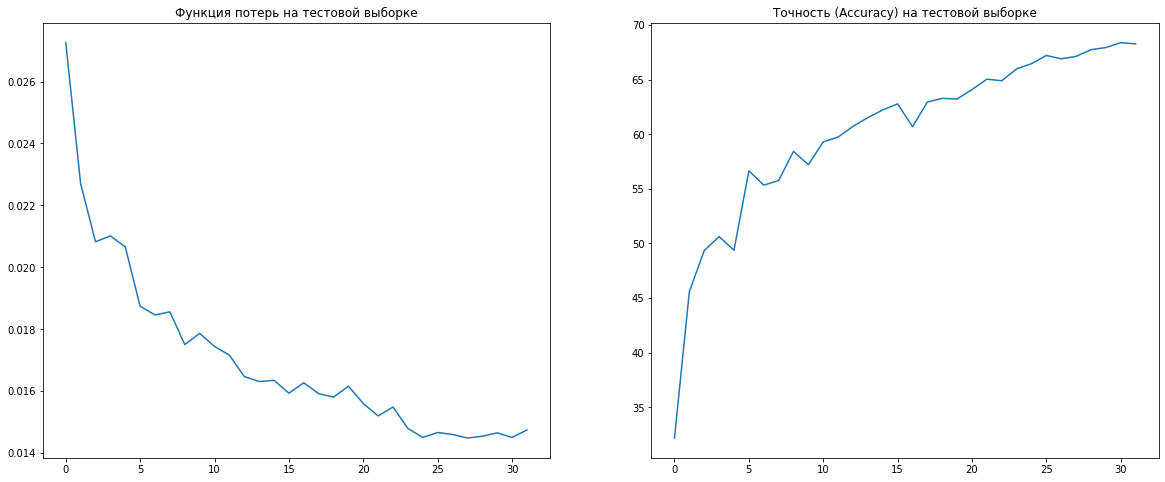

In [98]:
model=Net(1.0)
model.to(device)
epochs=32
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print(f"Эпоха {epoch}: LR: {get_lr(optimizer)}")
    train(model, training_generator, optimizer,scheduler)
    test(model, validation_generator)
    #scheduler.step()
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

<font size=6><b>5. Сохранение модели

In [99]:
torch.save(model, 'FER2013_MODEL.pth')

<font size=6><b>6. Визуализация результатов